### Load the required imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from yellowbrick.classifier import ClassificationReport, ROCAUC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

In [2]:

# Settings to display all columns
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [3]:
data = pd.read_csv("bank-full.csv")

In [4]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,Target
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


### Data Exploration
 - There are no missing values
 - There are outliers and negative values (from data.describe, its evident with "balance" feature)

In [5]:
data.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
Target       0
dtype: int64

In [6]:
data.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
Target       45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [8]:
data.select_dtypes(include=[np.number]).columns

Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object')

### EDA Part 1: Univariate (Categorical)

 - Historical dataset contains more people with job of  "Management", "Blue-Collar" and "Technician"
 - Majority of the population is having secondary education 
 - The mode of communication is mostly through Cellular and maximum people are reached out in the month of May
 - Percentage of people with personal loans are comparitively less 
 - Target distribution shows its more of an imbalanced data with 1:8 ration of yes/no
 - There are lot of "unknown" categories in the poutcome feature, which is the mode in this case as well. Without having clear understanding of the data, making them as either "success" or "failure" would introduce bias, so treating them as seperate category. Same is applicable for mode of communication too

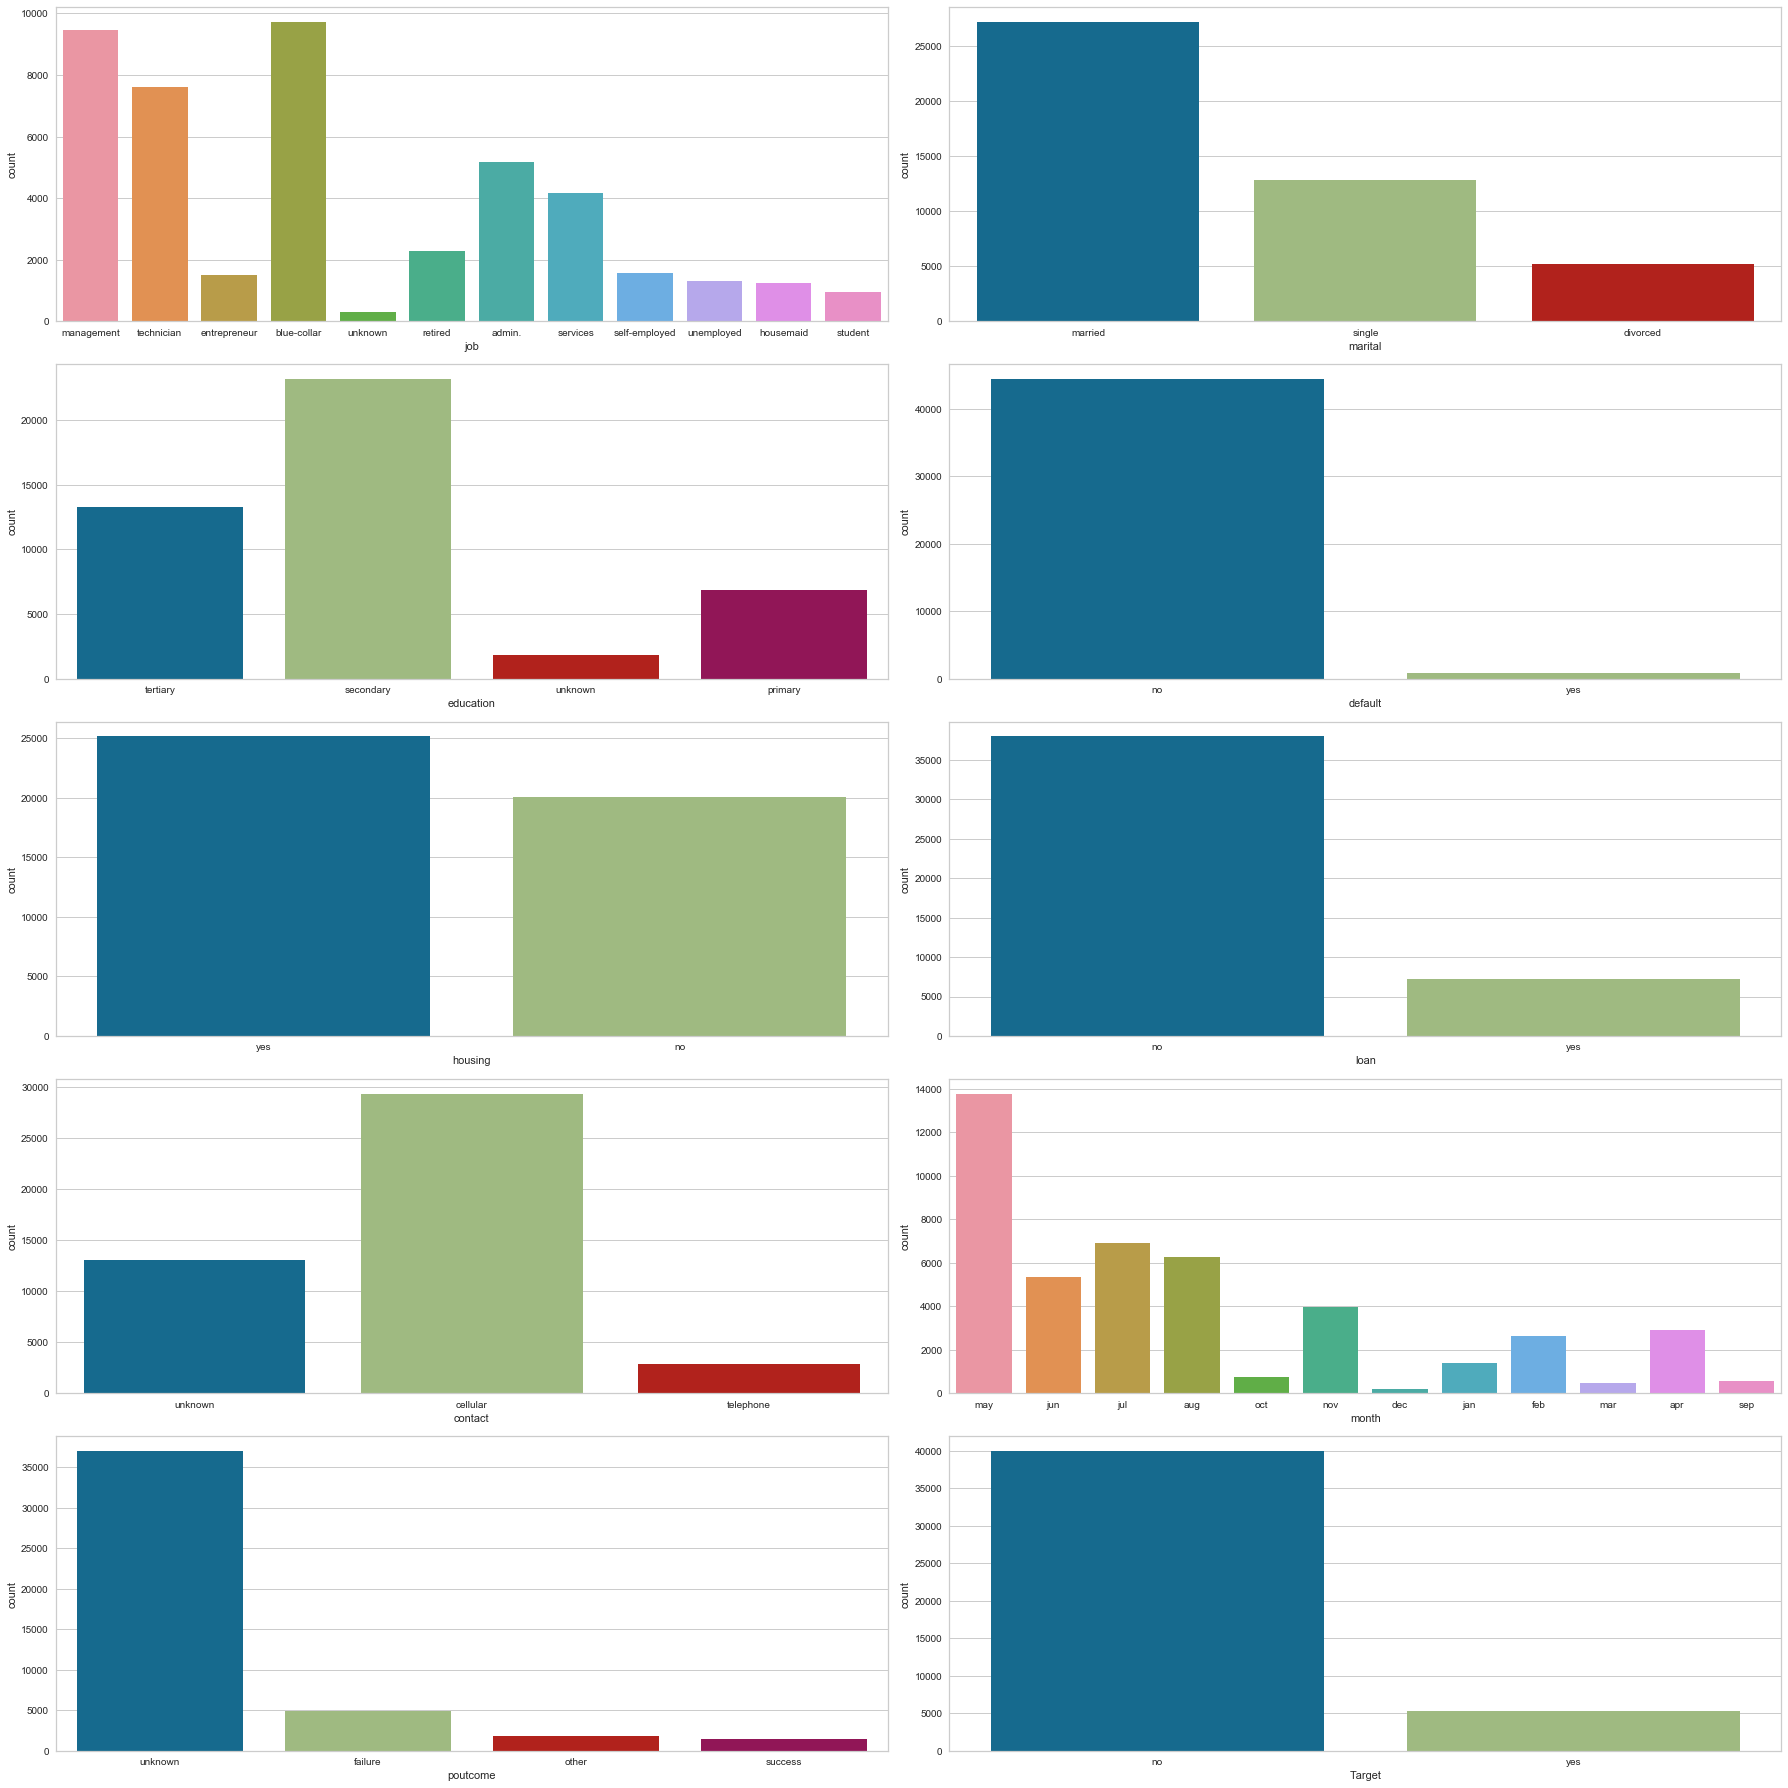

In [9]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
fig, ax = plt.subplots(5, 2, figsize=(25, 25))
for variable, subplot in zip(cat_cols, ax.flatten()):
    sns.countplot(data[variable], ax=subplot)
plt.tight_layout()

### EDA Part 2: Univariate (Numeric)
 - Maximum value of balance is 102127 and the minimum value is coming as negative. Needs data cleaning and outlier removal process
 - Age can be categorized using binning to avoid the effect of outliers
 - Duration also shows skewed distribution and normalization/Min-Max technique can be used to reduce the impact

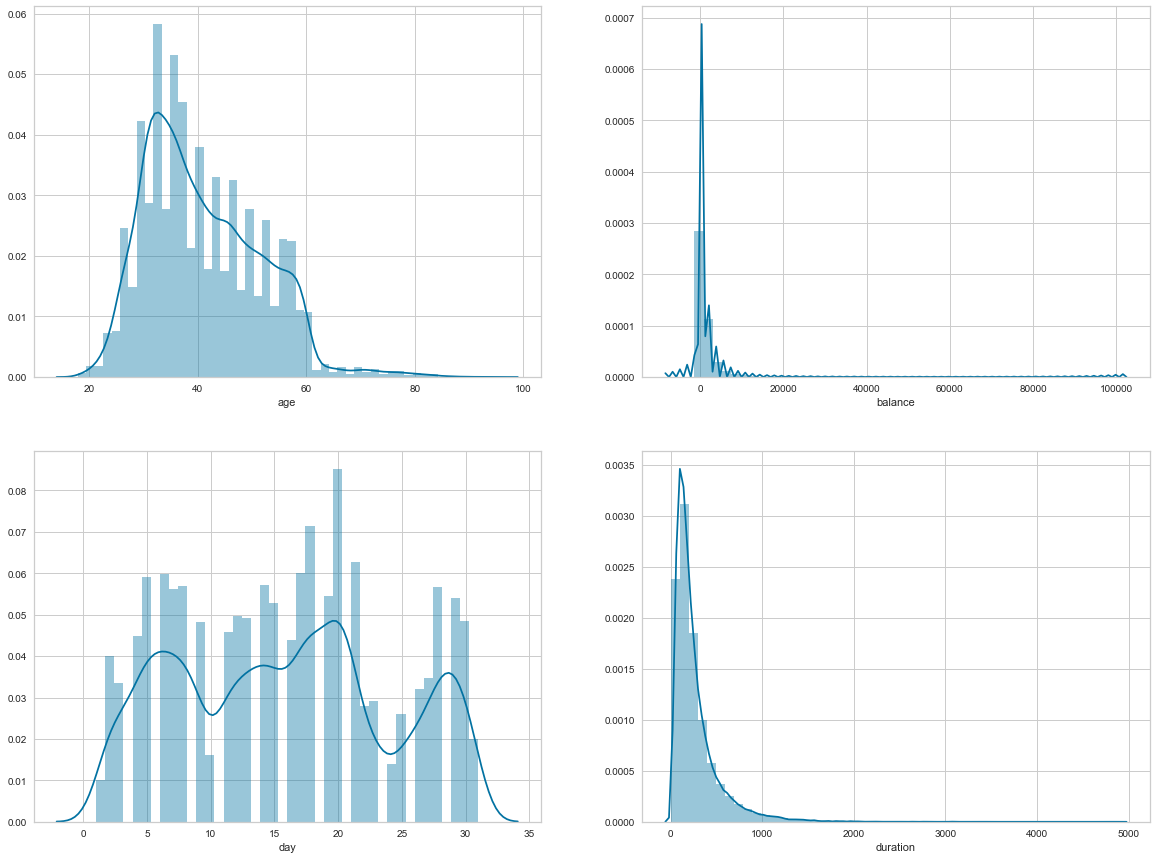

In [10]:
numeric_cols = list(data.select_dtypes(include=[np.number]).columns)
fig, ax = plt.subplots(2, 2, figsize=(20, 15))
for variable, subplot in zip(numeric_cols, ax.flatten()):
    sns.distplot(data[variable], ax=subplot)


### EDA : Correlation Analysis
 - Correlation heat map shows there is no correlation between input variables


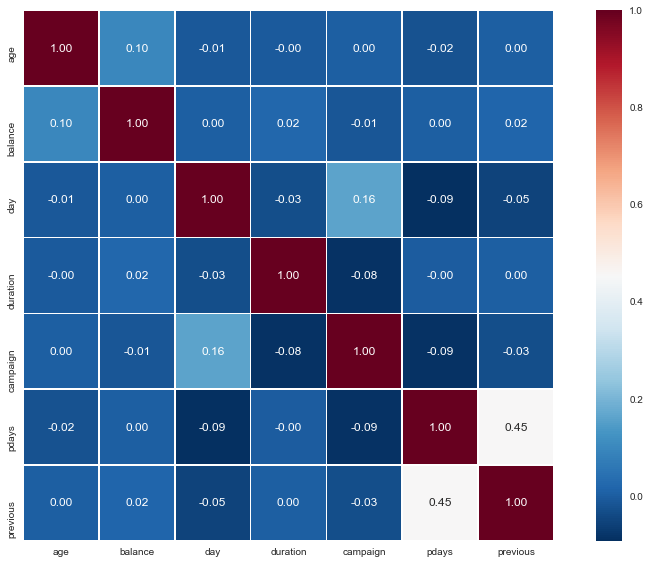

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(data._get_numeric_data().astype(float).corr(),
            square=True, cmap='RdBu_r', linewidths=.5,
            annot=True, fmt='.2f').figure.tight_layout()
plt.show()

### EDA : Bivariate Analysis with Target column
 - People without housing and personal loans had subscribed to the term deposit more
 - People who subscribed during each month is in proportion to the number of people who have been contacted
 - People with teritiary education had subscribed more

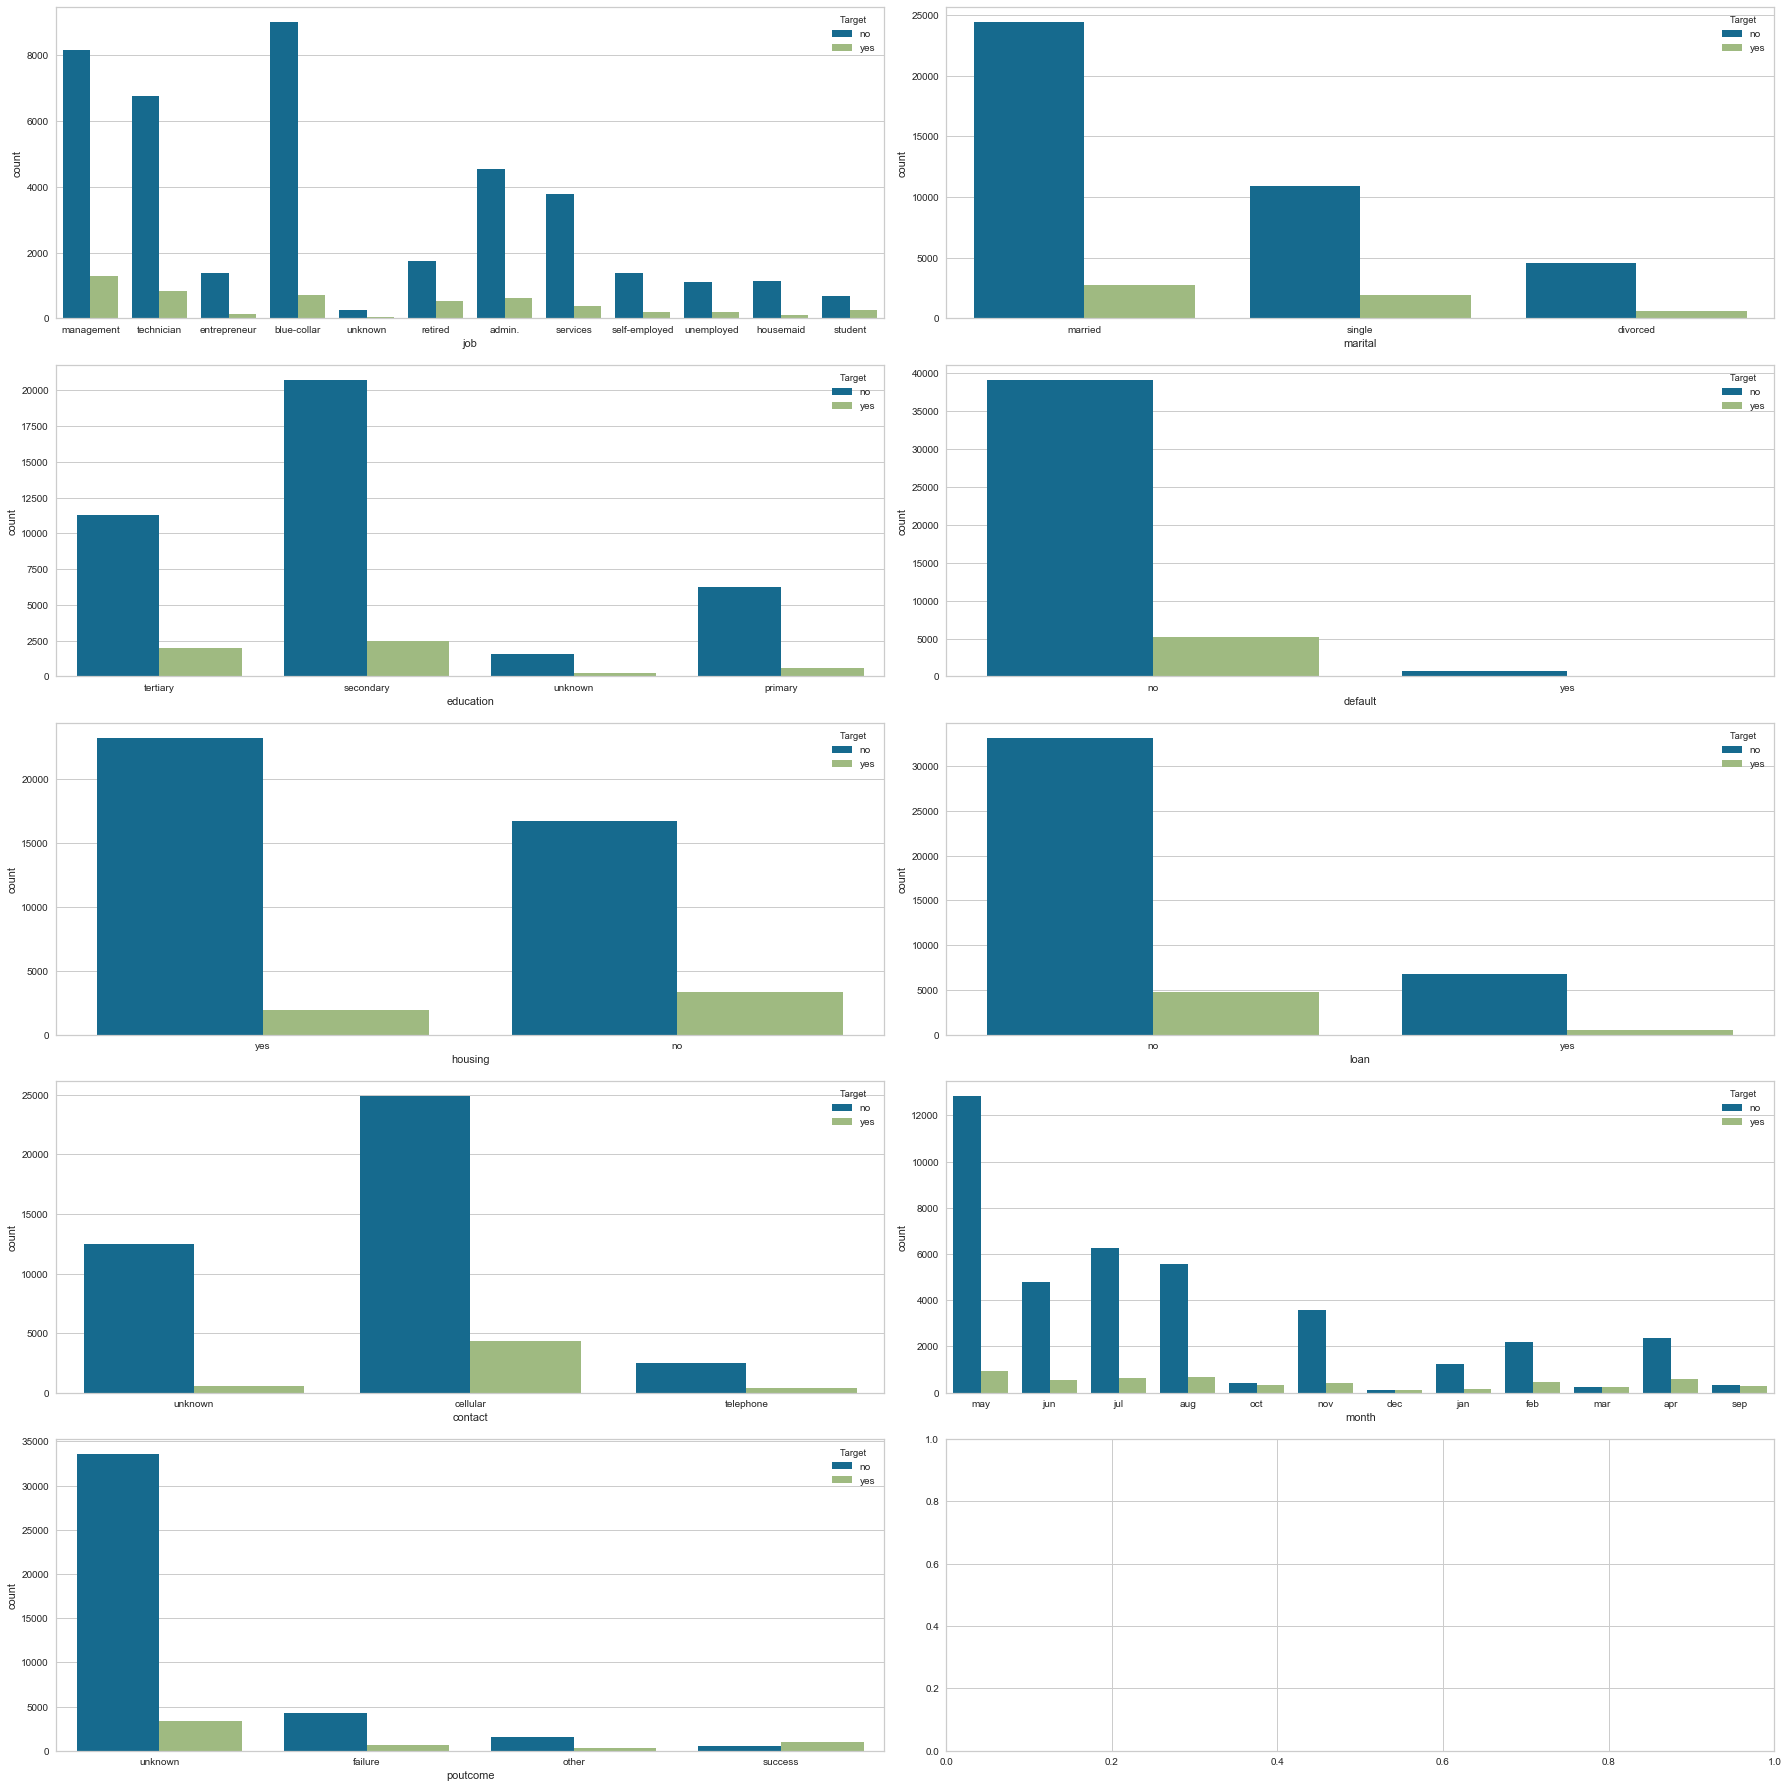

In [12]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
cat_cols.remove('Target')
fig, ax = plt.subplots(5, 2, figsize=(25, 25))
for variable, subplot in zip(cat_cols, ax.flatten()):
    sns.countplot(data[variable], ax=subplot,hue=data['Target'])
plt.tight_layout()

### Data pre-processing
 - Taking absolute value for balance
 - Applying MinMax scalar for "duration" feature
 - Dividing Age into multiple bins and use it as categorical one

In [13]:
data['balance'] = abs(data['balance'])
minmaxScalar = MinMaxScaler()
data['balance']= minmaxScalar.fit_transform(np.array(data['balance']).reshape(-1,1))
data['duration']= minmaxScalar.fit_transform(np.array(data['duration']).reshape(-1,1))
data.drop('poutcome',axis=1,inplace=True)

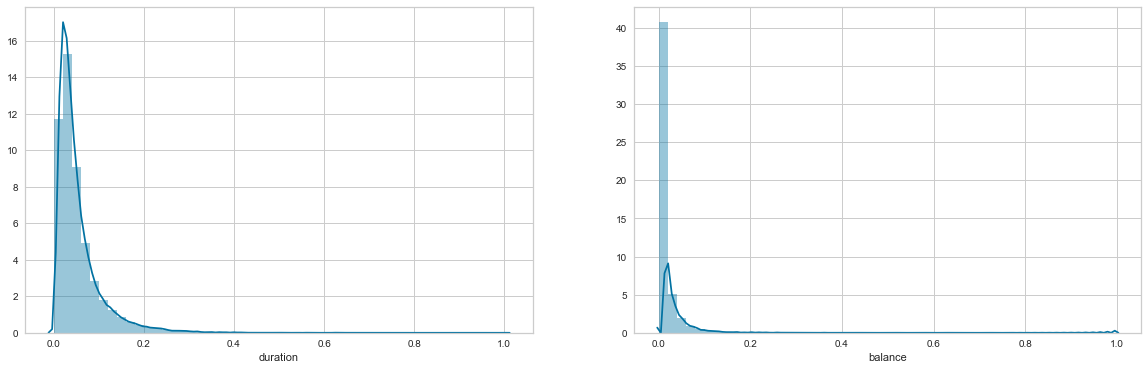

In [14]:
numeric_cols = ['duration','balance']
fig, ax = plt.subplots(1, 2, figsize=(20, 6))
for variable, subplot in zip(numeric_cols, ax.flatten()):
    sns.distplot(data[variable], ax=subplot)

In [15]:
age_bin_edges = [0,30,40,50,60,100]         
age_bin_labels = ['0-30','30-40','40-50','50-60','60-100']
data['age_bins'] = pd.cut(data['age'], bins=age_bin_edges , labels=age_bin_labels)

In [16]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,Target,age_bins
0,58,management,married,tertiary,no,0.020984,yes,no,unknown,5,may,0.053070,1,-1,0,no,50-60
1,44,technician,single,secondary,no,0.000284,yes,no,unknown,5,may,0.030704,1,-1,0,no,40-50
2,33,entrepreneur,married,secondary,no,0.000020,yes,yes,unknown,5,may,0.015453,1,-1,0,no,30-40
3,47,blue-collar,married,unknown,no,0.014746,yes,no,unknown,5,may,0.018707,1,-1,0,no,40-50
4,33,unknown,single,unknown,no,0.000010,no,no,unknown,5,may,0.040260,1,-1,0,no,30-40


In [17]:
cat_cols = list(data.select_dtypes(include=['object']).columns)
cat_cols.remove('Target')
cat_cols.append('age_bins')
data_updated = pd.get_dummies(data,columns=cat_cols,drop_first=True)

In [18]:
data_updated.head()

,age,balance,day,duration,campaign,pdays,previous,Target,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_married,marital_single,education_secondary,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,age_bins_30-40,age_bins_40-50,age_bins_50-60,age_bins_60-100
0,58,0.020984,5,0.053070,1,-1,0,no,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0
1,44,0.000284,5,0.030704,1,-1,0,no,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
2,33,0.000020,5,0.015453,1,-1,0,no,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0
3,47,0.014746,5,0.018707,1,-1,0,no,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
4,33,0.000010,5,0.040260,1,-1,0,no,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0


### Converting the target variable to binary value

In [19]:
data_updated['Target'] = data_updated['Target'].apply(lambda x: 1 if x=='yes' else 0)

In [20]:
X =data_updated.drop('Target', axis=1)
y= data_updated['Target']

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [22]:
def get_best_model(X,y,model,params):   
    rs = RandomizedSearchCV(model, params, cv=3, n_jobs=-1,
                              verbose=1, scoring='roc_auc')
    model = rs.fit(X,y)
    return model.estimator

In [23]:
def get_classification_report(X,y,model):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Visualize model performance with yellowbrick library
    viz = ClassificationReport(model)
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.show()

    roc = ROCAUC(model)
    roc.fit(X_train, y_train)
    roc.score(X_test, y_test)
    roc.show()

In [24]:
from sklearn.model_selection import KFold,cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics

models = []
models.append(('LR', LogisticRegression()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=50)))
models.append(('GB', GradientBoostingClassifier(n_estimators=50)))
models.append(('Adaboost', AdaBoostClassifier(n_estimators=50)))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_fit = model.fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    roc_score = roc_auc_score(y_test,y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    results.append([name,accuracy,roc_score,auc_score])

results = pd.DataFrame(results,columns=['Model','Accuracy','ROC',"AUC"])
results.head()

/Users/k0t02vy/opt/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


,Model,Accuracy,ROC,AUC
0,LR,0.880787,0.539601,0.539601
1,CART,0.871277,0.690368,0.690368
2,RF,0.903789,0.675720,0.675720
3,GB,0.896270,0.640281,0.640281
4,Adaboost,0.895311,0.654106,0.654106


### Comparing CART and RF for Precision and Recall since they both have good accuracy

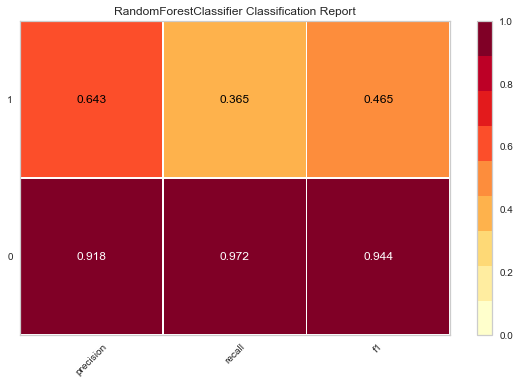

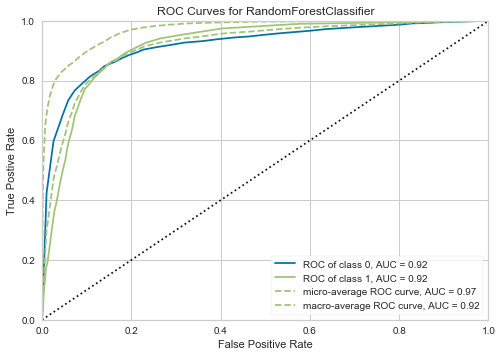

In [25]:
rf= RandomForestClassifier(n_estimators=50)
get_classification_report(X,y,rf)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    3.4s finished


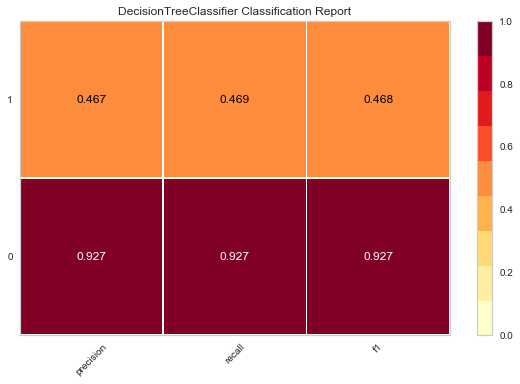

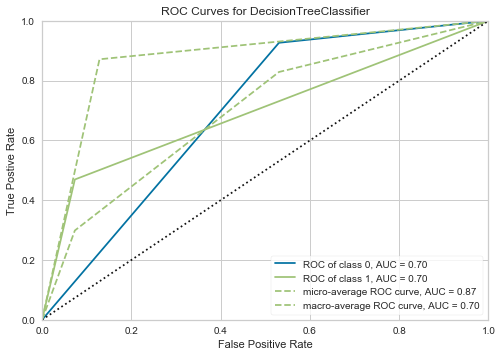

In [26]:
dtparams = { 'criterion': ['gini', 'entropy'], 'max_depth':[2,3,5,8,10], 'min_samples_leaf':[2,3,5,8,10]}
dtModel = DecisionTreeClassifier()
dtBestModel = get_best_model(X_train,y_train,dtModel,dtparams)
get_classification_report(X,y,dtModel)

### Inference
 - Ensembling Techniques(Random Forest, Gradient Boosting, Adaboost) performs better than Logisitc Regression and Decision tree in terms of accuracy
 - Since the dataset is imbalanced one, precision and recall are preferred over the accuracy. And with that, Decision tree performs better than the other algorithms
 - Compared Decision Tree and Random Forest for Precision and Recall. 
 - Random Forest has better precision than CART but it has lesser Recall than Logisitc Regression
 - Based on the business requirements, we can choose one over the other algorithm



### Plotting Feature Importance for Random Forest and Decision Tree
 

In [27]:
def plot_feat_imp(coef, features, name):
    feature_importances = pd.DataFrame(abs(coef),
                                       index = features,
                                        columns=['importance']).sort_values('importance',ascending=False)
    plt.figure(figsize=(15,12))
    plt.title(name)
    feature_importances.sort_values('importance',ascending=False,inplace=True)
    plt.tight_layout()
    feature_importances_updated = feature_importances.head(10)
    b= sns.barplot(x=feature_importances_updated.importance, y=feature_importances_updated.index)
    b.tick_params(labelsize=13)

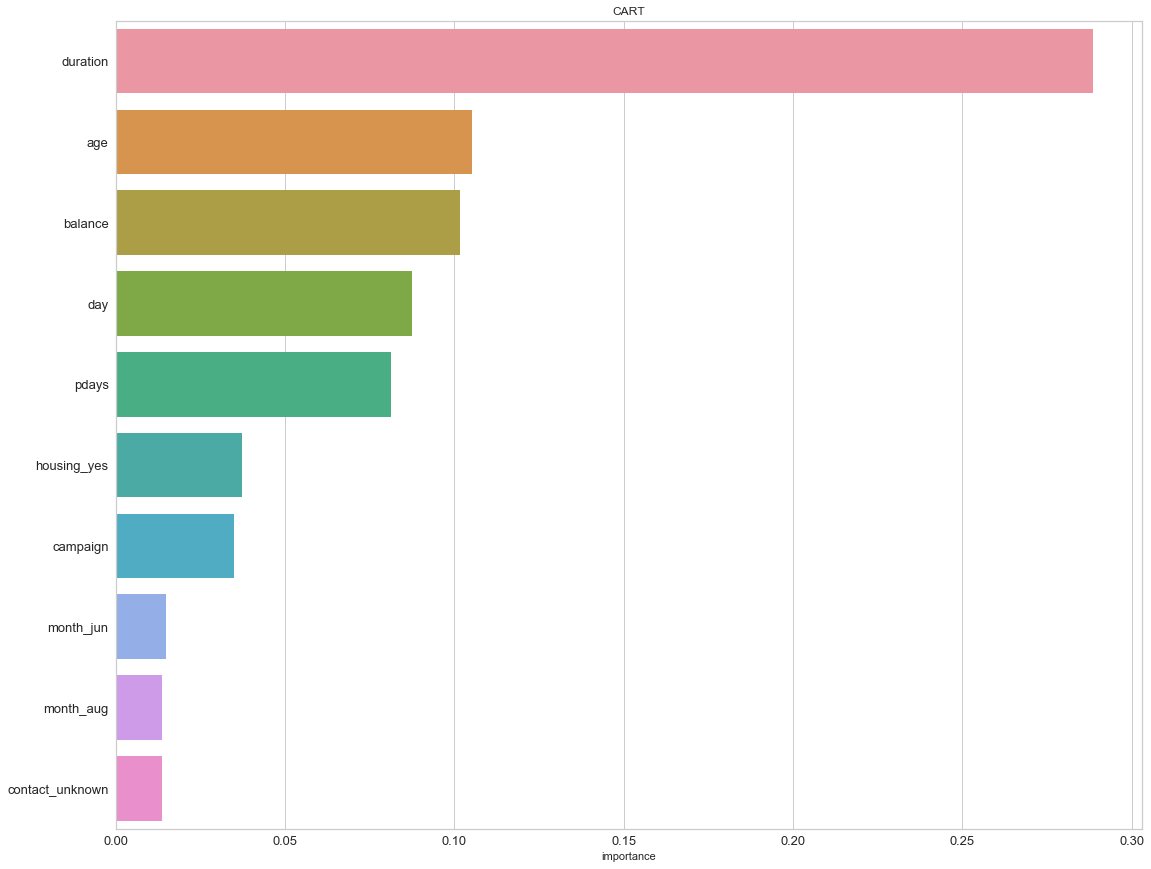

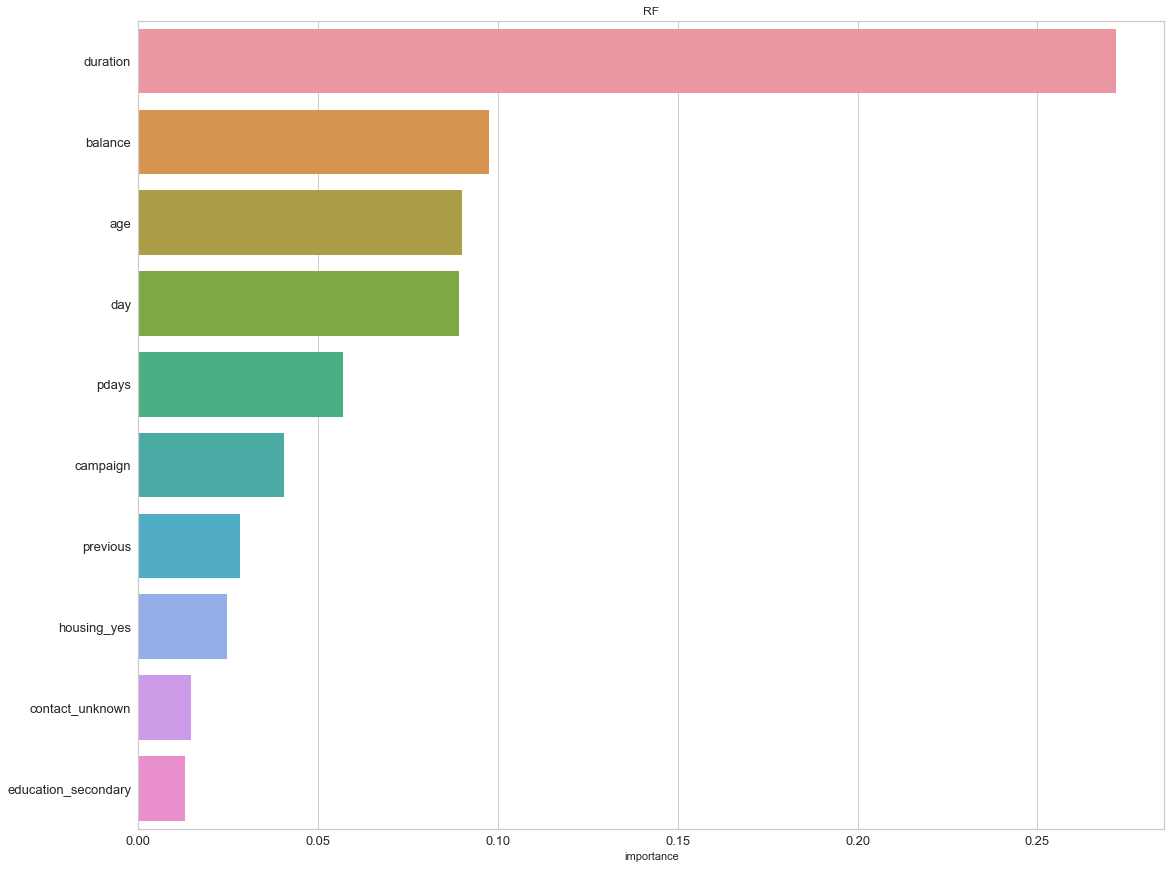

In [28]:
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=50)))

# evaluate each model in turn
results = []
names = []

for name, model in models:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model_fit = model.fit(X_train, y_train)
#     print("Feature importance for ", name)
    plot_feat_imp(model_fit.feature_importances_,X_train.columns,name)

### Conclusion: 1
 - Longer the duration of the call higher the chance that the customer is subscribing term deposit (But this cannot be explained well since customers who are subscribed obivously had more duration of the call)
 - Balance and the age are more reliable factors and we can use this feature for targeting (Based on the AI fairness, we should restrict the usage of age)
 - day of the week in which the customer is being contacted has great impact on term subscription. 
 

### Lets try with removing the duration feature
 - Removing the duration had reduced ROC a lot
 - So we can go with first conclusion and try to have marketing campaign for longer duration

  Model  Accuracy       ROC       AUC
0  CART  0.820997  0.598974  0.598974
1  RF    0.886096  0.576769  0.576769
Feature importance for  RF


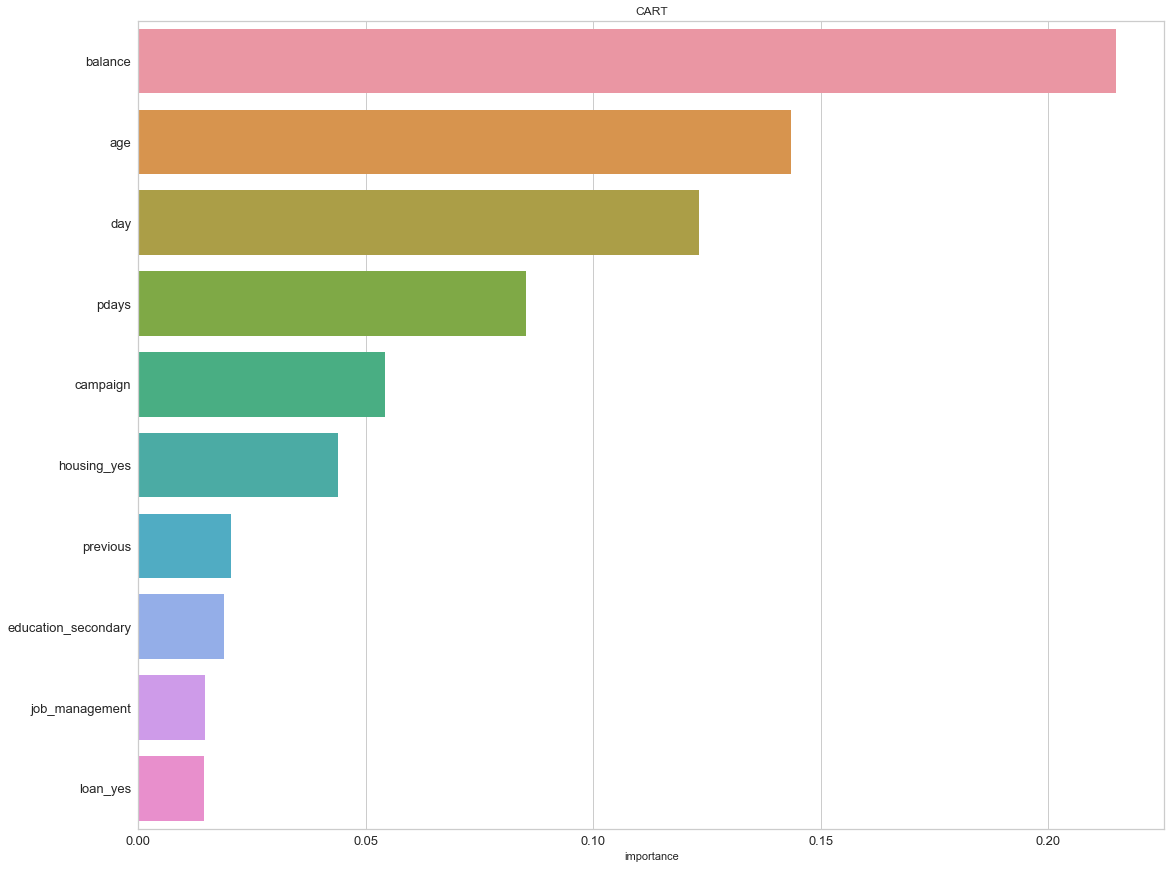

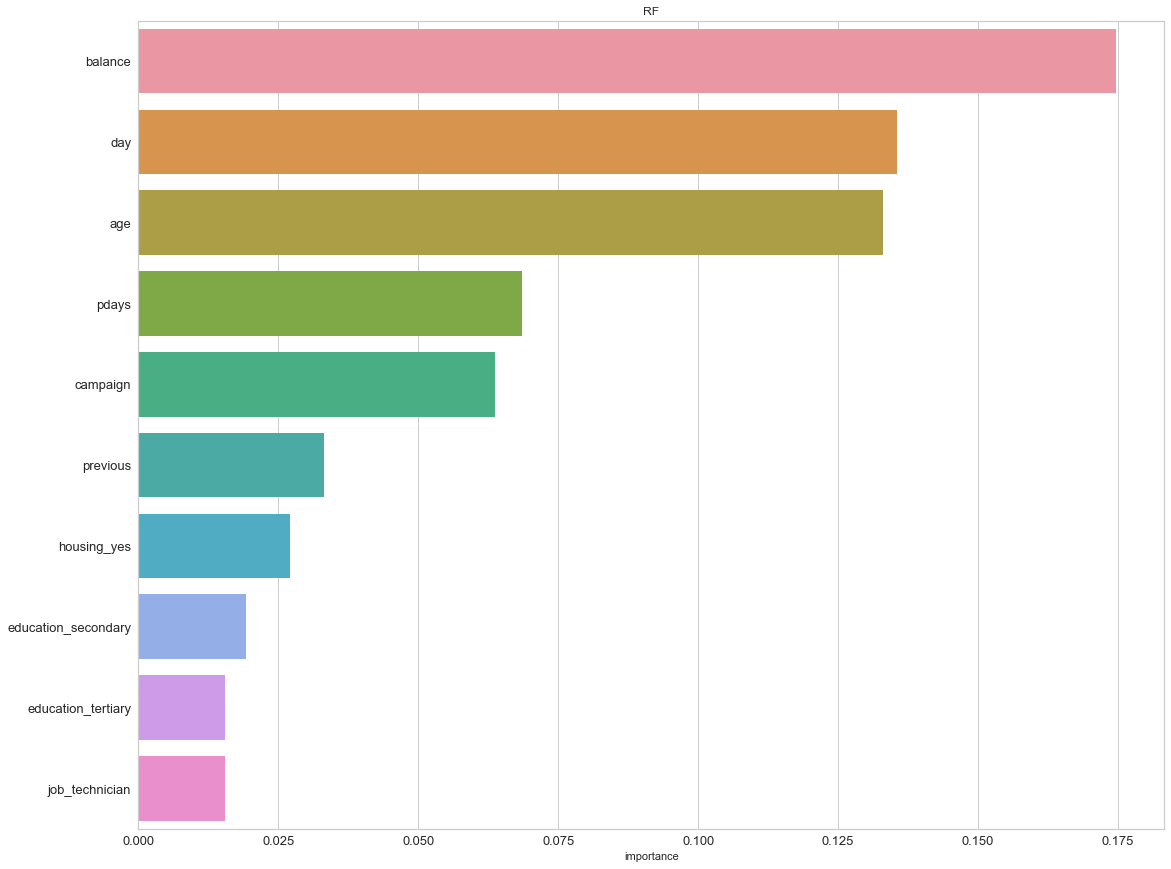

In [29]:
models = []
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier(n_estimators=50)))

# evaluate each model in turn
results = []
names = []

X_updated = X.drop('duration',axis=1)

for name, model in models:
    X_train, X_test, y_train, y_test = train_test_split(X_updated, y, test_size=0.3, random_state=42)
    model_fit = model.fit(X_train, y_train)
    y_pred = model_fit.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    roc_score = roc_auc_score(y_test,y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    auc_score = metrics.auc(fpr, tpr)
    results.append([name,accuracy,roc_score,auc_score])
    plot_feat_imp(model_fit.feature_importances_,X_train.columns,name)

results = pd.DataFrame(results,columns=['Model','Accuracy','ROC',"AUC"])
print(results.head())
print("Feature importance for ", name)
    